# Long Short-Term Memory Network with Keras

LSTM은 Backpropagation Through Time (BPTT)를 통해서 학습을 하며, vanishing gradient problem을 극복합니다.<br>
일반적인 Deep Learning에서 사용하는 Neurons들은 없고, layers들로 연결된 Memory Block을 갖고 있습니다. 

Block은 gates의 요소를 갖고 있으며, Gates는 block의 state를 관리하게 됩니다.<br>
일반적으로 다음과 같은 gates를 갖고 있습니다.

* Forget Gate: 어떤 정보를 버릴지 정합니다.
* Input Gate: Input 데이터에서 어떤 값들을 memory state에 업데이트할지 결정합니다.
* Output Gate: Input값과 memory block에 기초하여 어떤 결과값(output)을 낼지 결정합니다.


In [1]:
%pylab inline
%env CUDA_VISIBLE_DEVICES=""
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Reshape
from keras.callbacks import History, TensorBoard

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

np.random.seed(0) # fix the random number

Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=""


Using TensorFlow backend.


## Configuration

In [2]:
BATCH = 1
LOOK_BACK = 1

## Data

International Airline Pessengers

In [3]:
# Load Data
data = pd.read_csv('../../data/time-series/international-airline-passengers.csv', 
                   names=['passenger'],
                   skiprows=1, usecols=[1])

data = data.as_matrix()

# Normalize Data using Min-Max Scaler 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = data.astype('float32')

# Seperate Train and Test Data
_size = int(len(data) * 0.7) # 144
train, test = data[:_size], data[_size:] # 100, 44

# To time-series dataset
def to_timeseries(x, batch:int):
    n = len(x)
    train = np.zeros((n-batch, batch, 1))
    test = np.zeros((n-batch, batch, 1))
    
    for i in range(n - batch):
        train[i] = x[i:i+batch]
        test[i] = x[i+batch:i+batch+1]
    return train, test

x_train, y_train = to_timeseries(train, batch=BATCH)
x_test, y_test = to_timeseries(test, batch=BATCH)

print('train:  ', train.shape)
print('test:   ', test.shape)
print('train_x:', x_train.shape)
print('train_y:', y_train.shape)
print('test_x: ', x_test.shape)
print('test_y: ', y_test.shape)


train:   (100, 1)
test:    (44, 1)
train_x: (99, 1, 1)
train_y: (99, 1, 1)
test_x:  (43, 1, 1)
test_y:  (43, 1, 1)


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


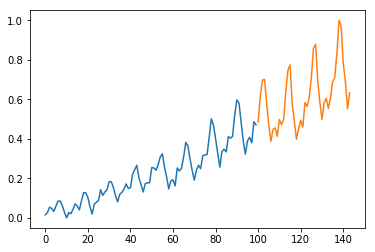

In [4]:
x1 = range(len(train))
x2 = range(len(train), len(train) + len(test))
plot(x1, train)
plot(x2, test)

## TensorBoard

In [5]:
# History
tensorboard_filepath = '/tmp/international_airline_passenger_logs'
if os.path.exists(tensorboard_filepath):
    shutil.rmtree(tensorboard_filepath)

history = History()
tensorboard = TensorBoard('/tmp/international_airline_passenger_logs')

## Model

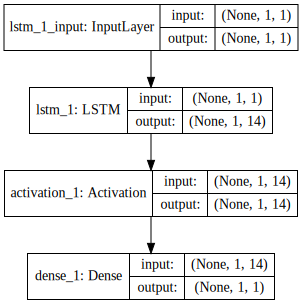

In [6]:
def create_model():
    np.random.seed(0)
    model = Sequential(name='LSTM Model')
    model.add(LSTM(14, return_sequences=True,
                            batch_input_shape=(None, BATCH, 1)))
    model.add(Activation('selu'))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# # Visualization
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training for Normalized Data

In [7]:
model = create_model()
model.fit(x_train, y_train, epochs=14, batch_size=BATCH, verbose=2, callbacks=[history, tensorboard])

Epoch 1/14
0s - loss: 0.0387
Epoch 2/14
0s - loss: 0.0158
Epoch 3/14
0s - loss: 0.0133
Epoch 4/14
0s - loss: 0.0112
Epoch 5/14
0s - loss: 0.0093
Epoch 6/14
0s - loss: 0.0076
Epoch 7/14
0s - loss: 0.0063
Epoch 8/14
0s - loss: 0.0050
Epoch 9/14
0s - loss: 0.0041
Epoch 10/14
0s - loss: 0.0033
Epoch 11/14
0s - loss: 0.0028
Epoch 12/14
0s - loss: 0.0025
Epoch 13/14
0s - loss: 0.0023
Epoch 14/14
0s - loss: 0.0022


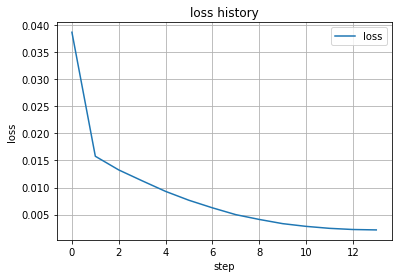

In [8]:
plot(history.history['loss'], label='loss')
title('loss history')
xlabel('step')
ylabel('loss')
# ylim(0, 0.01)
grid()
legend()

## Evaluate normalized data

In [9]:
def evaluate(model, scaler, x, y_true):
    y_pred = model.predict(x)
    
    y_pred = y_pred.reshape(-1, 1)
    y_true = y_true.reshape(-1, 1)
    
    print('MSE:', mean_squared_error(y_pred, y_true))
    print('R^2:', r2_score(y_pred, y_true))
    return y_pred

print('[Evaluate Training]')
train_pred = evaluate(model, scaler, x_train, y_train)

print('\n[Evaluate Test]')
test_pred = evaluate(model, scaler, x_test, y_test)

[Evaluate Training]
MSE: 0.00216878231639
R^2: 0.869044514567

[Evaluate Test]
MSE: 0.00918493735961
R^2: 0.561610974043


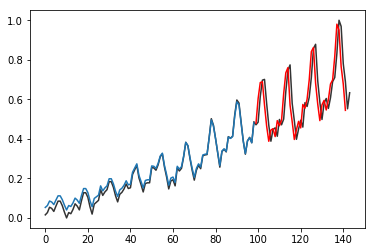

In [10]:
def plot_result(data, train_pred, test_pred):
    _x1 = np.arange(len(data))
    _x2 = np.arange(len(train_pred))
    _x3 = np.arange(len(train_pred), len(train_pred) + len(test_pred))
    
    plot(_x1, data, color='#333333')
    plot(_x2, train_pred)
    plot(_x3, test_pred, color='red')
    
plot_result(data, train_pred, test_pred)